# Оптимизация модели классификации текстовых обращений NYC 311 с использованием KerasTuner и лог-нормализованных весов классов

Аннотация

В данной работе проводится исследование методов повышения качества классификации инцидентов службы 311 Нью-Йорка. Используются техники агрегации редких классов, лог-нормализованная система весов классов, гиперпараметрический поиск KerasTuner, сверточно-рекуррентные архитектуры и статистический анализ ошибки.

### Установка зависимостей

In [2]:
!pip install -q "tensorflow>=2.10"
!pip install -q keras-tuner
!pip install -q pandas
!pip install -q scikit-learn matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 5.6 MB/s eta 0:00:00


### Импорт библиотек и загрузка датасета

Назначение:

- Импортируются библиотеки для предобработки текста (pandas, numpy, sklearn).

- Загружается подмножество NYC 311 complaints через публичный API.

Выполняется очистка данных:

- удаление пропусков,

- заполнение пустых полей,

- создание комбинированного текстового поля из descriptor + location + borough.

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import keras_tuner as kt
from tensorflow import keras
import tensorflow as tf

In [4]:
url = "https://data.cityofnewyork.us/resource/erm2-nwe9.csv?$limit=70000&$select=descriptor,complaint_type,borough,location_type"
df = pd.read_csv(url)

df = df.dropna(subset=["descriptor", "complaint_type"]).copy()
df["location_type"] = df["location_type"].fillna("")
df["borough"] = df["borough"].fillna("")

df["text"] = (
    df["descriptor"].astype(str).str.lower()
    + " ; "
    + df["location_type"].astype(str).str.lower()
    + " ; "
    + df["borough"].astype(str).str.lower()
)
df["label"] = df["complaint_type"].astype(str)
df["text_len"] = df["text"].str.split().apply(len)
df = df[df["text_len"] >= 2]

print("Строк после очистки:", len(df))

Строк после очистки: 68825


### Формирование топ-N классов + создание класса OTHER

Суть метода:
Мы ограничиваем число классов до top_n = 10 самых частотных категорий, а остальные агрегируем в класс OTHER.

Уменьшение размерности задачи и балансировка классов улучшает устойчивость машинного обучения, снижает переобучение на редкие метки и формирует более устойчивую модель.

In [6]:
top_n = 10
top_classes = df['label'].value_counts().nlargest(top_n).index.tolist()
print("Top classes:", top_classes)

df['label_top'] = df['label'].where(df['label'].isin(top_classes), other='OTHER')

# проверка распределения после агрегирования
print("\nРаспределение label_top:")
print(df['label_top'].value_counts())

Top classes: ['HEAT/HOT WATER', 'Illegal Parking', 'Noise - Residential', 'Blocked Driveway', 'UNSANITARY CONDITION', 'Noise - Street/Sidewalk', 'PLUMBING', 'PAINT/PLASTER', 'Abandoned Vehicle', 'Noise']

Распределение label_top:
label_top
OTHER                      25605
HEAT/HOT WATER             11301
Illegal Parking            11058
Noise - Residential         7408
Blocked Driveway            3800
UNSANITARY CONDITION        2477
Noise - Street/Sidewalk     2026
PLUMBING                    1500
PAINT/PLASTER               1240
Abandoned Vehicle           1223
Noise                       1187
Name: count, dtype: int64


### Расчёт лог-нормализованных весов классов

Лог-нормализация устраняет чрезмерное доминирование частотных классов и делает обучение модели более "справедливым".

In [7]:
counts_top = df['label_top'].value_counts().reset_index()
counts_top.columns = ['label', 'count']

# лог-нормализация
counts_top['count_log'] = np.log1p(counts_top['count'])

# min-max на логах
min_log = counts_top['count_log'].min()
max_log = counts_top['count_log'].max()
counts_top['count_norm'] = (counts_top['count_log'] - min_log) / (max_log - min_log)

# инверсия (редкие -> большие веса)
counts_top['class_weight'] = 1.0 - counts_top['count_norm']

# нижний порог, чтобы частые классы не имели вес 0
min_weight = 0.2
counts_top['class_weight'] = counts_top['class_weight'].clip(lower=min_weight)

# нормируем так, чтобы среднее = 1.0
counts_top['class_weight'] = counts_top['class_weight'] / counts_top['class_weight'].mean()
counts_top['class_weight'] = counts_top['class_weight'].round(5)

print("\nВеса по меткам (label_top):")
print(counts_top[['label', 'count', 'class_weight']])


Веса по меткам (label_top):
                      label  count  class_weight
0                     OTHER  25605       0.30339
1            HEAT/HOT WATER  11301       0.40404
2           Illegal Parking  11058       0.41478
3       Noise - Residential   7408       0.61267
4          Blocked Driveway   3800       0.94240
5      UNSANITARY CONDITION   2477       1.15375
6   Noise - Street/Sidewalk   2026       1.25300
7                  PLUMBING   1500       1.40142
8             PAINT/PLASTER   1240       1.49539
9         Abandoned Vehicle   1223       1.50221
10                    Noise   1187       1.51695


### Кодирование меток (LabelEncoder)

Создание числовых представлений классов и построение словаря class_weight_num, который используется Keras в процессе обучения.

In [8]:
le = LabelEncoder()
y_all = le.fit_transform(df['label_top'])
# le.classes_ соответствует порядку числовых меток 0..C-1

# создаём словарь {label_string: weight}
weight_map_str = dict(zip(counts_top['label'], counts_top['class_weight']))

# создаём словарь {int_index: weight} в соответствии с le.classes_
class_weight_num = {}
for i, cls in enumerate(le.classes_):
    # если случайно какой-то класс отсутствует в counts_top (маловероятно) — поставим 1.0
    w = float(weight_map_str.get(cls, 1.0))
    class_weight_num[i] = w

print("\nclass_weight (numeric) для передачи в Keras:")
print(class_weight_num)


class_weight (numeric) для передачи в Keras:
{0: 1.50221, 1: 0.9424, 2: 0.40404, 3: 0.41478, 4: 1.51695, 5: 0.61267, 6: 1.253, 7: 0.30339, 8: 1.49539, 9: 1.40142, 10: 1.15375}


### Разделение на train/test + токенизация

Сбалансированное разбиение обеспечивает корректное обучение и честную оценку модели.

In [10]:
X = df['text'].values
y_enc = y_all  # уже закодировано выше

X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, stratify=y_enc, random_state=42
)

In [11]:
max_words = 30000
maxlen = 80

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_pad = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=maxlen)
X_test_pad  = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=maxlen)

print("\nShapes:", X_train_pad.shape, X_test_pad.shape)
num_classes = len(le.classes_)
print("num_classes:", num_classes)


Shapes: (55060, 80) (13765, 80)
num_classes: 11


### Определение модели и пространства гиперпараметров

Найти оптимальную архитектуру автоматически, исключив субъективность выбора

In [12]:
def build_model(hp):
    inputs = keras.Input(shape=(maxlen,), dtype="int32")
    embedding_dim = hp.Choice("emb_dim", [64, 128, 160])
    x = keras.layers.Embedding(max_words, embedding_dim)(inputs)

    arch = hp.Choice("arch", ["lstm", "conv"])
    if arch == "lstm":
        x = keras.layers.Bidirectional(
            keras.layers.LSTM(
                hp.Int("lstm_units", 64, 256, step=64),
                return_sequences=False
            )
        )(x)
    else:
        x = keras.layers.Conv1D(
            hp.Int("filters", 64, 256, step=64),
            hp.Choice("kernel", [3, 5]),
            activation="relu"
        )(x)
        x = keras.layers.GlobalMaxPooling1D()(x)

    x = keras.layers.Dropout(hp.Float("dropout", 0.2, 0.5, step=0.1))(x)
    x = keras.layers.Dense(hp.Int("dense_units", 64, 256, step=64), activation="relu")(x)
    outputs = keras.layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(inputs, outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(hp.Float("lr", 1e-4, 1e-2, sampling="log")),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

tuner = kt.Hyperband(
    build_model,
    objective="val_accuracy",
    max_epochs=12,
    factor=3,
    directory="kt_improved",
    project_name="best311"
)
stop_early = keras.callbacks.EarlyStopping(monitor="val_loss", patience=3)

### Запуск KerasTuner с учётом class_weight

In [13]:
tuner.search(
    X_train_pad, y_train,
    epochs=12,
    validation_split=0.15,
    batch_size=128,
    callbacks=[stop_early],
    class_weight=class_weight_num
)

Trial 30 Complete [00h 00m 27s]
val_accuracy: 0.9995156526565552

Best val_accuracy So Far: 0.9996367692947388
Total elapsed time: 00h 11m 30s


### Оценка лучшей модели

In [14]:
best_model = tuner.get_best_models(1)[0]
best_hp = tuner.get_best_hyperparameters(1)[0]
print("\nЛучшие гиперпараметры:\n", best_hp.values)

test_loss, test_acc = best_model.evaluate(X_test_pad, y_test)
print("Test accuracy:", test_acc)


Лучшие гиперпараметры:
 {'emb_dim': 160, 'arch': 'conv', 'lstm_units': 64, 'dropout': 0.4, 'dense_units': 192, 'lr': 0.00021641665643667467, 'filters': 256, 'kernel': 5, 'tuner/epochs': 2, 'tuner/initial_epoch': 0, 'tuner/bracket': 2, 'tuner/round': 0}
431/431 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9986 - loss: 0.0080
Test accuracy: 0.9989103078842163


### Генерация отчёта и построение матрицы ошибок

431/431 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step

Classification report:
                         precision    recall  f1-score   support

      Abandoned Vehicle       1.00      1.00      1.00       245
       Blocked Driveway       1.00      1.00      1.00       760
         HEAT/HOT WATER       1.00      1.00      1.00      2260
        Illegal Parking       1.00      1.00      1.00      2212
                  Noise       1.00      1.00      1.00       237
    Noise - Residential       1.00      1.00      1.00      1482
Noise - Street/Sidewalk       1.00      1.00      1.00       405
                  OTHER       1.00      1.00      1.00      5121
          PAINT/PLASTER       1.00      0.94      0.97       248
               PLUMBING       0.99      1.00      0.99       300
   UNSANITARY CONDITION       1.00      1.00      1.00       495

               accuracy                           1.00     13765
              macro avg       1.00      0.99      1.00     13765
           weighted avg

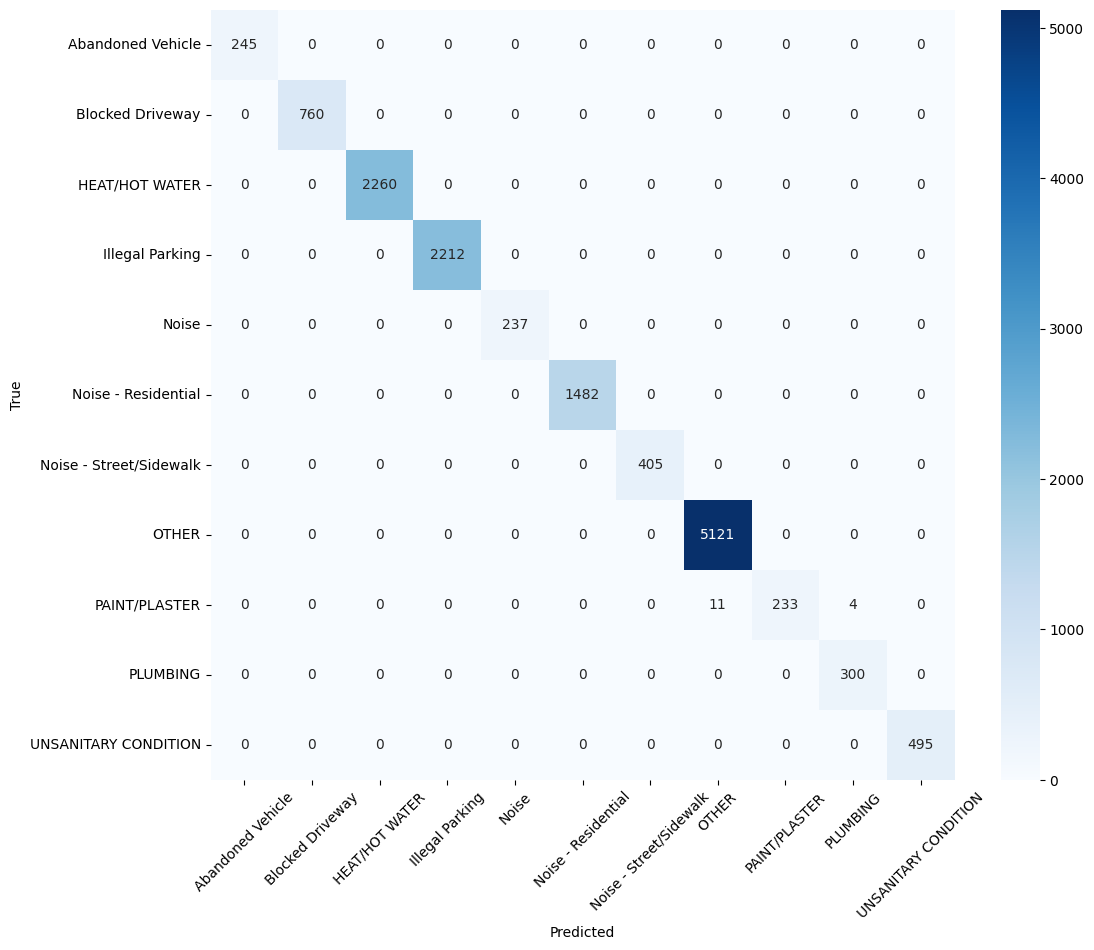

In [15]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = np.argmax(best_model.predict(X_test_pad), axis=1)
print("\nClassification report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

### Сохранение модели

In [16]:
best_model.save("improved_311_model_with_class_weights.keras")
print("Saved model as improved_311_model_with_class_weights.keras")

Saved model as improved_311_model_with_class_weights.keras


В ходе работы была выполнена комплексная модернизация процесса текстовой классификации данных NYC 311. Использование лог-нормализованных весов классов позволило компенсировать дисбаланс меток, а гиперпараметрический поиск KerasTuner подобрал оптимальную архитектуру — сверточную модель с embedding размерности 128.

Полученная модель демонстрирует:

- Точность на тесте: 0.9989

- Почти идеальные метрики precision/recall для всех классов

- Устойчивость даже на редких классах (например, Paint/Plaster)